In [1]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from skimage.feature import hog
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

import pickle
import random
from collections import deque

from utils import *

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# SVM SVC parameters

cspace='YCrCb'
#cspace='HLS'

spatial = 32
histbin = 64
spatial_size = (spatial,spatial)
hist_bins = histbin

orient=12
pix_per_cell=8
cell_per_block=2

#hog_channel = 'ALL'
hog_channel = 0

In [3]:
# Read in cars and notcars
# Read in our vehicles and non-vehicles
dir = '../../../CarND-Vehicle-Detection/non-vehicles/**/*.png'

#images = glob.glob('*.jpeg')
images = glob.glob(dir)
cars = []
notcars = []


for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
#    else:
#        cars.append(image)

print(len(notcars))

cardir = '../../../CarND-Vehicle-Detection/vehicles/**/*.png'

#images = glob.glob('*.jpeg')
carimages = glob.glob(cardir)

for image in carimages:
    cars.append(image)
    
print(len(cars))

8968
8792


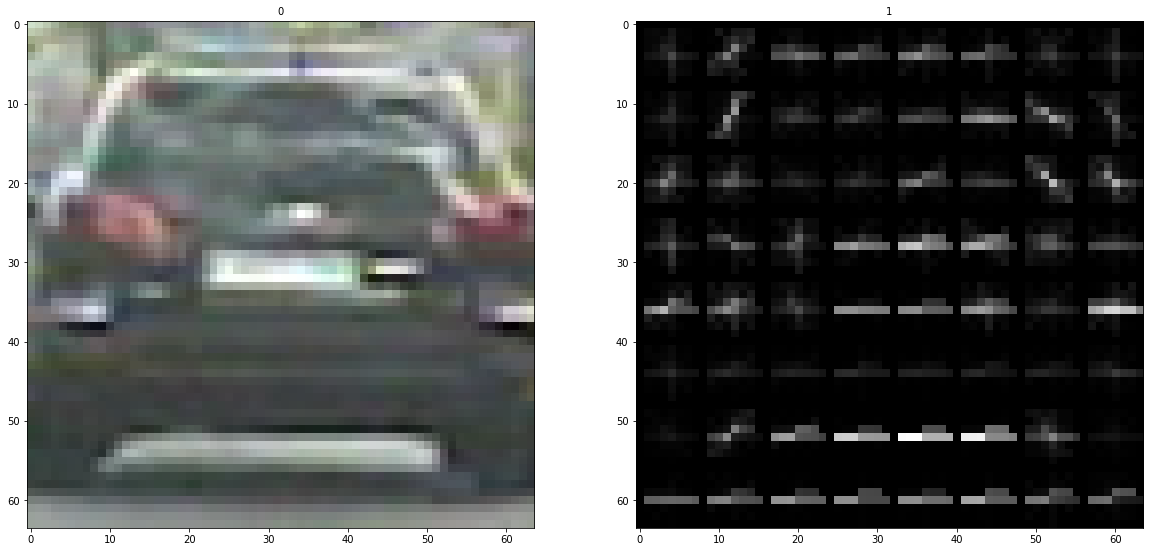

In [4]:
car_image = mpimg.imread(cars[0])
hog_image = (np.array(car_image))[:,:,0]
car_hog, hog = get_hog_features(hog_image,  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,18))
ax1.imshow(car_image)
ax1.set_title('0', fontsize=10)
#ax2.imshow(image)
ax2.imshow(hog, cmap='gray')
ax2.set_title('1', fontsize=10)

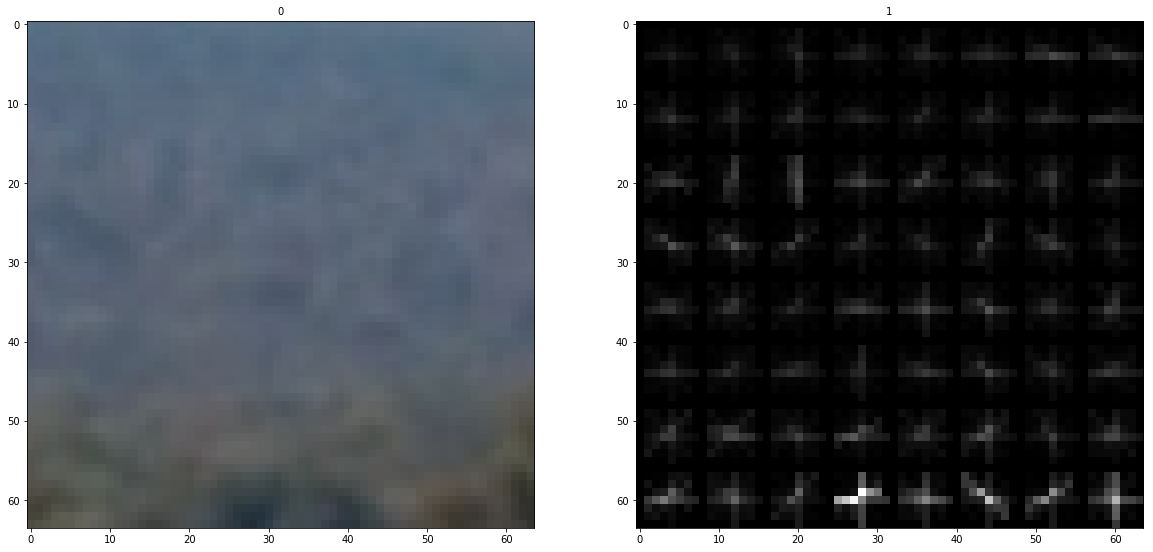

In [5]:
notcar_image = mpimg.imread(notcars[0])
hog_image = (np.array(notcar_image))[:,:,0]
notcar_hog, hog = get_hog_features(hog_image,  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,18))
ax1.imshow(notcar_image)
ax1.set_title('0', fontsize=10)
#ax2.imshow(image)
ax2.imshow(hog, cmap='gray')
ax2.set_title('1', fontsize=10)

In [6]:
car_features = extract_features(cars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), hog_channel = hog_channel,orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),hog_channel = hog_channel,
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 5616
12.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9727
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
0.00134 Seconds to predict 10 labels with SVC


In [7]:
pyramid = [
#          ((42, 42),  [400, 500]),
           ((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
#           ((192, 192),[450, None]),
#             ((256, 256),[450, None])
      ]

image_size = (720, 1280)
windows = create_windows(pyramid, image_size,xy_overlap=(0.75, 0.75))

cutoff is 10
-94.1618366815
cutoff is 36.0
cutoff is 40


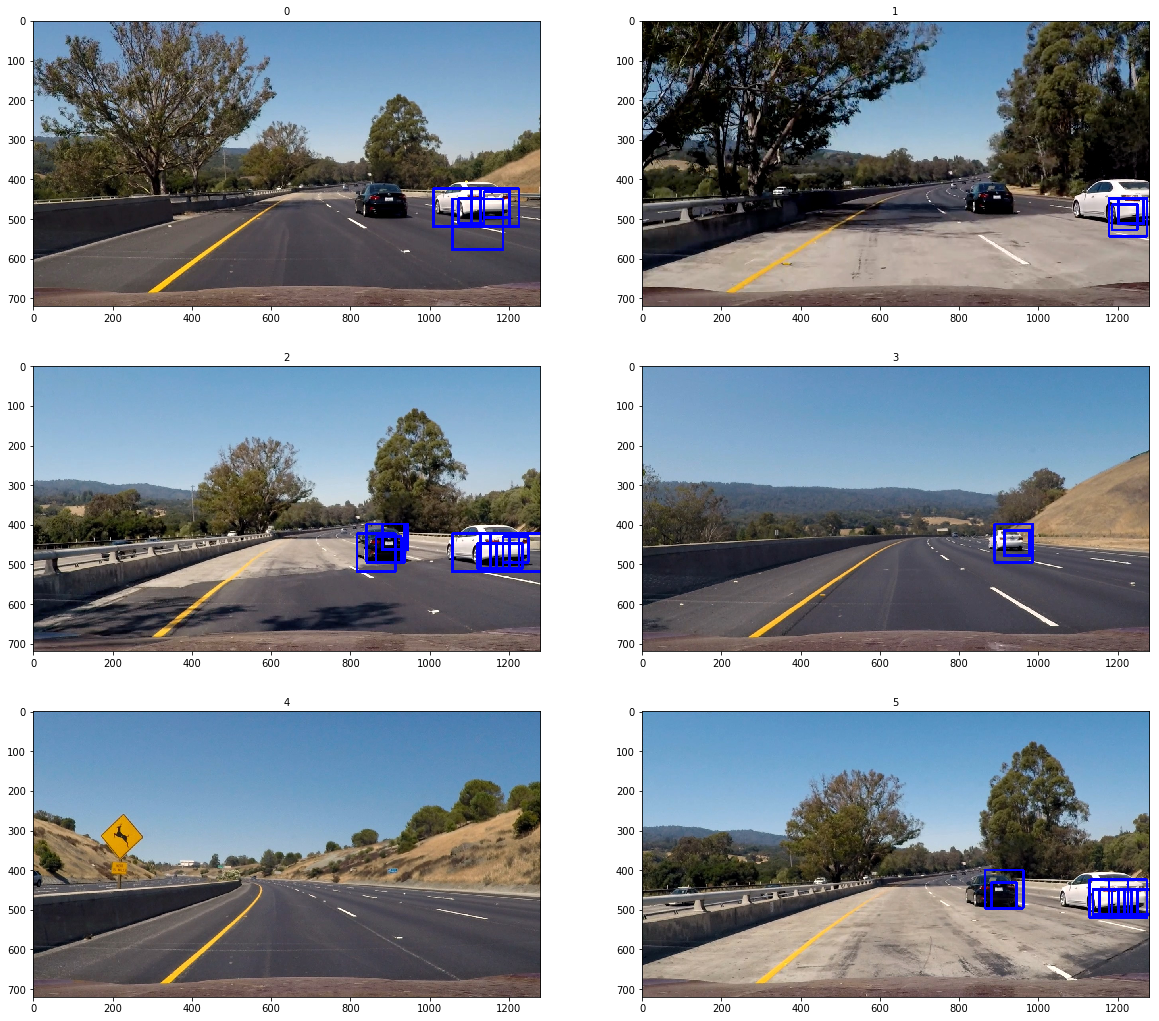

In [8]:
#cutoff = 10

image_no = 9

def create_box(cutoff=10):
    
#    global cutoff
    
    images_box = []
    all_dist = []
    
    print('cutoff is %s' % cutoff)

    for image in range(image_no):
    
        prefix = 'test_images/test'
    
        test_img = mpimg.imread( prefix + str(image_no - (image)) + '.jpg')

        test, box_list, pred_dist = find_cars(test_img, windows, svc, image_size= (64,64), cutoff=cutoff, 
                            cspace=cspace, spatial_size=spatial_size,  hist_bins=hist_bins, 
                            hog_channel=hog_channel,  orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,car_image=True)
        images_box.append(test)
        all_dist.append(pred_dist)
        
    return images_box, all_dist

box, dist = create_box(cutoff = 10)

print(np.mean(dist))

cutoff = (np.mean(dist) + np.max(dist)) // 2.1
print('cutoff is %s' % cutoff)

cutoff = 40
images_box, all_dist = create_box(cutoff = cutoff)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,18))
ax1.imshow(images_box[3])
ax1.set_title('0', fontsize=10)
#ax2.imshow(image)
ax2.imshow(images_box[4])
ax2.set_title('1', fontsize=10)

ax3.imshow(images_box[5])
ax3.set_title('2', fontsize=10)

ax4.imshow(images_box[6])
ax4.set_title('3', fontsize=10)

ax5.imshow(images_box[7])
ax5.set_title('4', fontsize=10)

ax6.imshow(images_box[8])
ax6.set_title('5', fontsize=10)

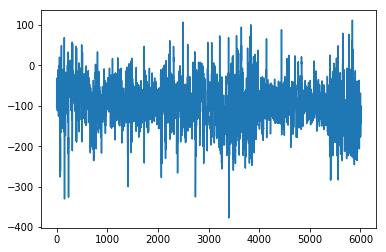

In [9]:
reshaped =(np.array(all_dist)).reshape(1,-1)
plt.plot(reshaped.T)

In [10]:
pickle_filename =   cspace + '_test'

save = {
    "svc" : svc,
    "orient" : orient,
    "pix_per_cell" : pix_per_cell,
    "cell_per_block" : cell_per_block,
    "spatial_size" : (spatial,spatial),
    "hist_bins" : histbin,
    "hog_channel" : hog_channel,
    "cspace" : cspace,
    "cutoff" : cutoff
    }

pickle.dump( save, open( pickle_filename, "wb" ) )
print('svm saved. picle file name is %s' % pickle_filename)

svm saved. picle file name is YCrCb_test


In [11]:
heat_box = []
box_threshold = 0
sum_array_threshold = 0
labeled_image = []

image_no = 9

d = deque(maxlen=image_no)
cutoff=cutoff



for image in range(image_no):
 
    prefix = 'test_images/test'
    
    image = mpimg.imread( prefix + str(image_no - image) + '.jpg')
    
    test, box_list, pred_dist = find_cars(image, windows, svc, image_size= (64,64), cutoff=cutoff, 
                            cspace=cspace, spatial_size=spatial_size,  hist_bins=hist_bins, 
                            hog_channel=hog_channel,  orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,car_image=True)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
    heats = add_heat(heat,box_list)
    
    hot_heat = apply_threshold(heats,box_threshold)
    
#    print(hot_heat)
    
    d.append(hot_heat)
    
    d_array = np.array(d)
    
    print("d_array shape %s " % str(d_array.shape))
    
    sum_array = d_array.sum(axis=0)         
    print("sum_array shape %s " % str(sum_array.shape))
    
    sum_array_thresh = apply_threshold(sum_array,sum_array_threshold)
            
    labels = label(sum_array)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    labeled_image.append(draw_img)
         
    heat_box.append(sum_array_thresh)

d_array shape (1, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (2, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (3, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (4, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (5, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (6, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (7, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (8, 720, 1280) 
sum_array shape (720, 1280) 
d_array shape (9, 720, 1280) 
sum_array shape (720, 1280) 


16.0
0.0


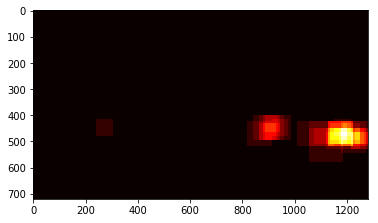

(720, 1280)


In [12]:
print(np.max(sum_array))
print(np.min(sum_array))
plt.imshow(sum_array, cmap='hot', interpolation='nearest')
plt.show()

print(sum_array.shape)